In [8]:
!pip install pip==23.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [17]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [9]:
!pip install -q torchvision catalyst

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.7/446.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.2 MB/s eta 0:00:00


In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
import time
import os

from torchvision import models, transforms
from torchvision.models import resnet50

from tqdm import tqdm, tqdm_notebook
from collections import Counter
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [45]:
#преобразование обучающих данных для расширения обучающей выборки и её нормализация
image_size = 224
train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(size=image_size, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [46]:
#папки с данными
train_dataset = datasets.ImageFolder(
    '/content/drive/MyDrive/journey-springfield/train/simpsons_dataset',
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    '/content/drive/MyDrive/journey-springfield/testset/',
    transform=test_transform
)


#вычисляем веса для каждого класса
class_counts = np.bincount([label for _, label in train_dataset.samples])
class_weights = 1.0 / class_counts  #чем меньше встречается класс, тем больше его вес

sample_weights = [class_weights[label] for _, label in train_dataset.samples]

train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

#создаем DataLoader для train, test
train_dataloader = DataLoader(
    train_dataset, batch_size=32, sampler=train_sampler, pin_memory=True, num_workers=4
)
test_dataloader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4
)

loaders = {
    "train": train_dataloader,
    "test": test_dataloader
}

class_names = train_dataset.classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
#обучение моделей
class Resnet50FineTuning(nn.Module):
    def __init__(self, class_counts):
        super(Resnet50FineTuning, self).__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        for param in self.resnet50.parameters():
            param.requires_grad = False

        for param in self.resnet50.layer4.parameters():
            param.requires_grad = True

        for param in self.resnet50.fc.parameters():
            param.requires_grad = True

        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, class_counts)

    def forward(self, x):
        return self.resnet50(x)


In [10]:
from catalyst import dl, metrics

class ImgRunner(dl.Runner):
    def predict_batch(self, batch):
        return self.model(batch[0].to(device))
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat,
            "loss": self.criterion(y_hat, y) if self.criterion else None
        }

In [40]:
@torch.no_grad()
def predict(model, test_loader):
    model.eval()
    preds = []
    labels = []
    for images, targets in tqdm(test_loader):
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        preds.append(outputs.argmax(dim=1).cpu().numpy())
        labels.append(targets.cpu().numpy())

    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    return preds, labels

In [29]:
def train(model, optimizer, criterion, train_loader, num_epoch, scheduler=None):
    for epoch in range(1, num_epoch + 1):
        train_accuracy = 0.0
        model.train()
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
        train_accuracy /= len(train_loader.dataset)
        if scheduler is not None:
            scheduler.step()
        print(f'Training batch accuracy {train_accuracy}')

        if scheduler is not None:
            scheduler.step()

In [30]:
#runner = ImgRunner()
model = Resnet50FineTuning(len(train_dataset.classes)).to(device)
model = nn.DataParallel(model)

num_epoch = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
train(model, optimizer, criterion, train_dataloader, num_epoch, scheduler)
#проблемы с версиями и средой???
#runner.train(
#    model=model,
#    optimizer=optimizer,
#    criterion=nn.CrossEntropyLoss(),
#    callbacks=[
#        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="loss"),
#        dl.OptimizerCallback(metric_key="loss"),
#        dl.AccuracyCallback(input_key="logits", target_key="targets"),
#    ],
#    loaders=loaders,
#    num_epochs=10,
#    main_metric=='f1',
#    verbose=True,
#    scheduler=scheduler,)

100%|██████████| 656/656 [04:37<00:00,  2.36it/s]


Training batch accuracy 0.8123242624982129


100%|██████████| 656/656 [03:49<00:00,  2.86it/s]


Training batch accuracy 0.9749797455082686


100%|██████████| 656/656 [03:21<00:00,  3.26it/s]


Training batch accuracy 0.9840823523804985


100%|██████████| 656/656 [03:09<00:00,  3.46it/s]


Training batch accuracy 0.9862269456226469


100%|██████████| 656/656 [03:05<00:00,  3.54it/s]


Training batch accuracy 0.9867988371538865


100%|██████████| 656/656 [03:04<00:00,  3.56it/s]


Training batch accuracy 0.9855120812085975


100%|██████████| 656/656 [02:59<00:00,  3.65it/s]


Training batch accuracy 0.9918028880522327


100%|██████████| 656/656 [02:59<00:00,  3.65it/s]


Training batch accuracy 0.9934232473907448


100%|██████████| 656/656 [03:00<00:00,  3.62it/s]


Training batch accuracy 0.9945193728256208


100%|██████████| 656/656 [02:59<00:00,  3.66it/s]


Training batch accuracy 0.9939474812943812


Predicting:   0%|          | 0/656 [00:02<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'append'

In [41]:
preds, labels = predict(model, train_dataloader)

f1 = f1_score(labels, preds, average='micro')
print(f'F1 Score: {f1:.4f}')

  0%|          | 0/656 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 656/656 [02:54<00:00,  3.75it/s]

F1 Score: 0.9963


In [51]:
type(test_dataloader)

torch.utils.data.dataloader.DataLoader

In [47]:
preds, labels = predict(model, test_dataloader)
test_dir = Path('/content/drive/MyDrive/journey-springfield/testset')
test_files = sorted(list(test_dir.rglob('*.jpg')))
file_names = [file.name for file in test_files]
name_class = {j : i for i, j in train_dataset.class_to_idx.items()}
preds_class = [name_class[pred] for pred in preds]

100%|██████████| 8/8 [00:27<00:00,  3.44s/it]


In [50]:
my_submission = pd.DataFrame({'Id': file_names, 'Expected': preds_class})
my_submission.to_csv('submission.csv', index=False)
my_submission

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,homer_simpson
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


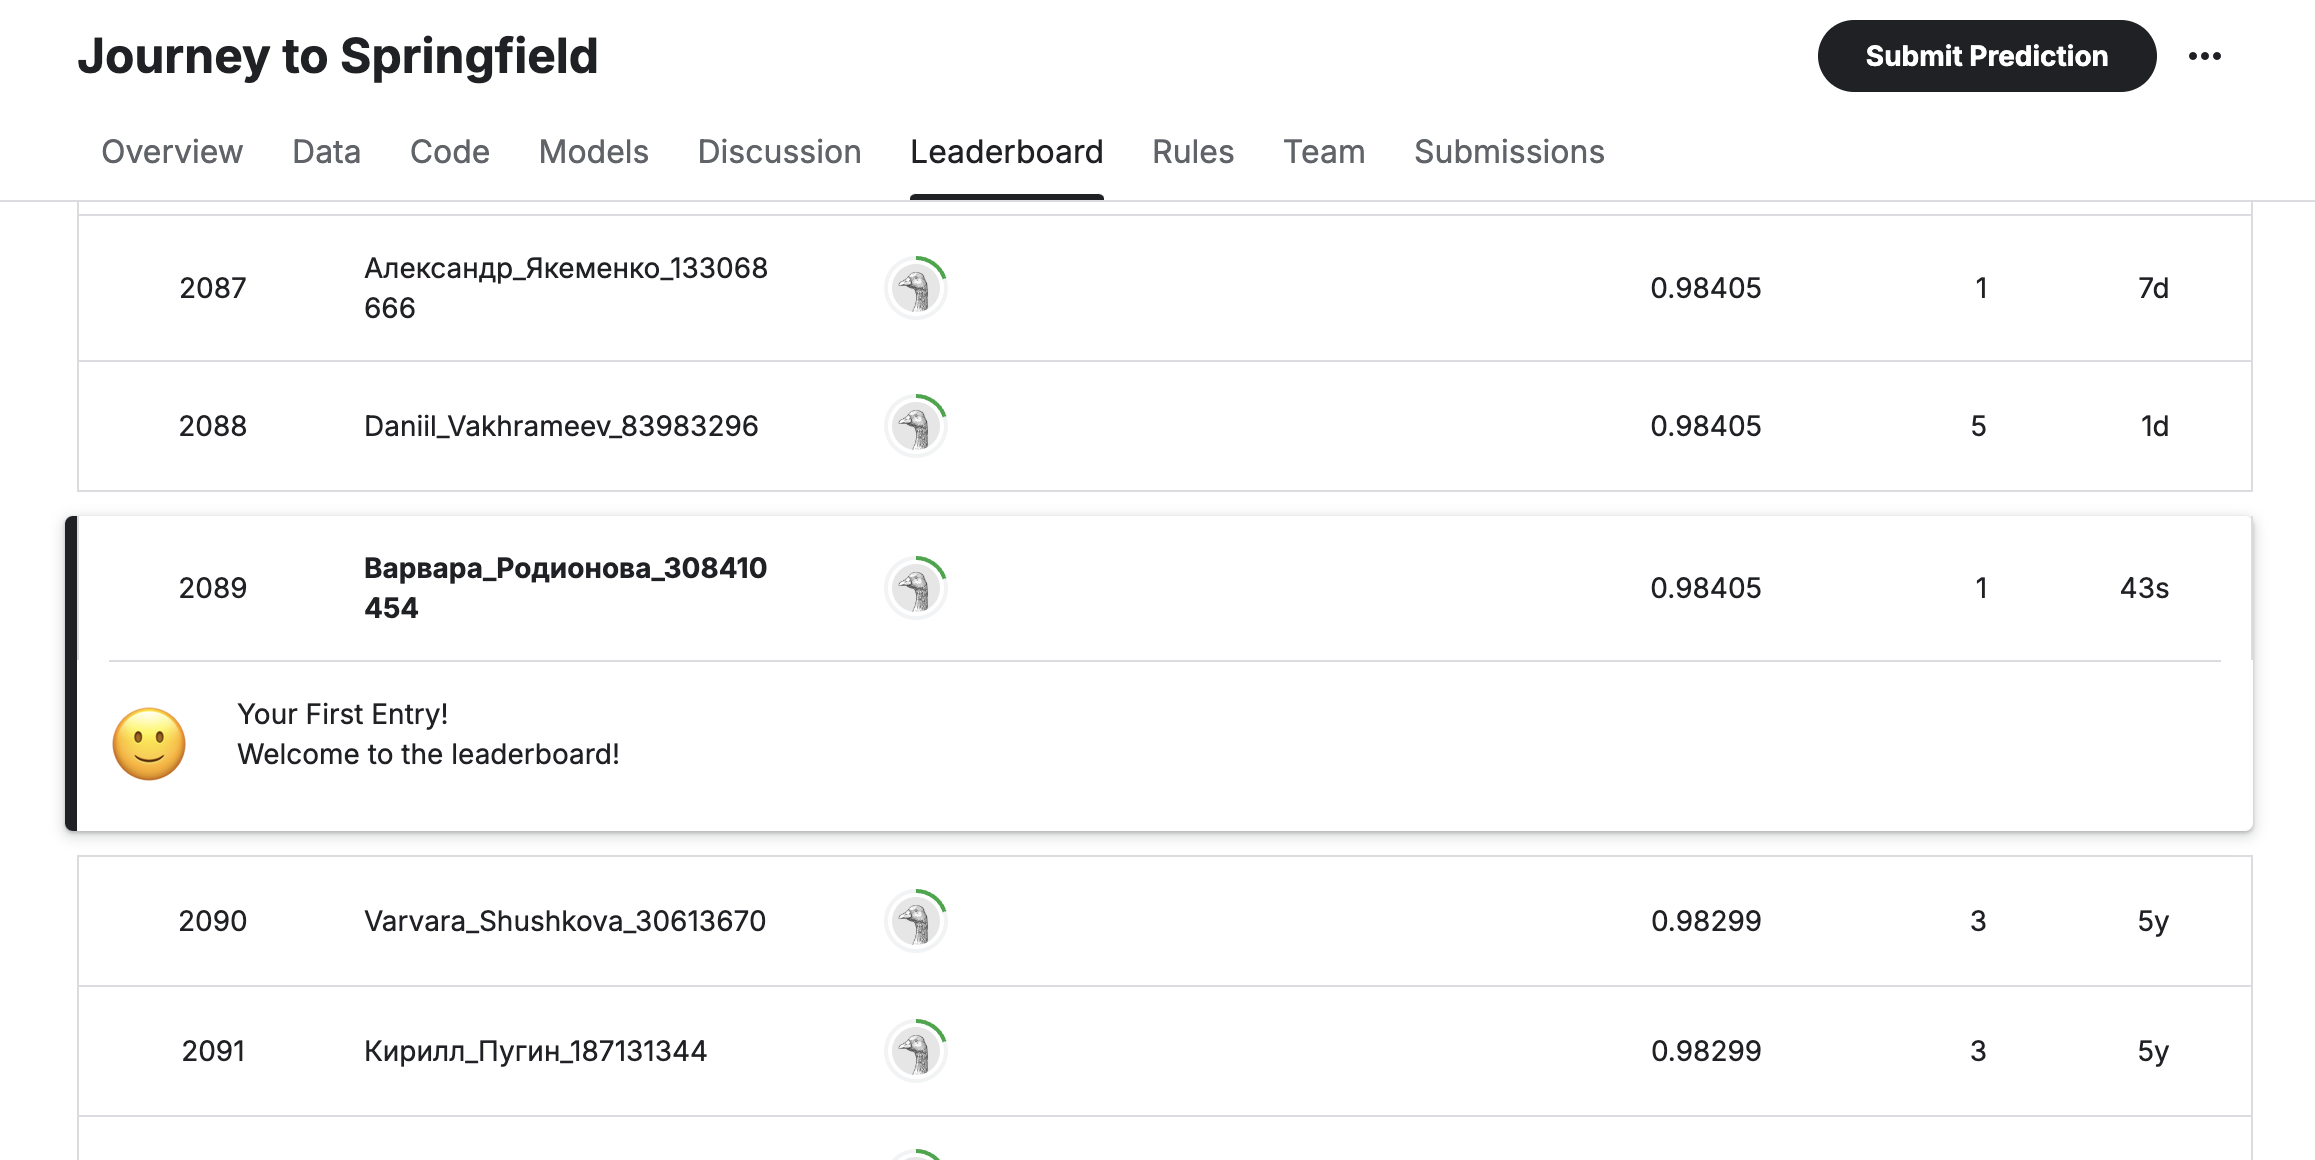